## Neural networks for segmentation

In [ ]:
! wget https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0 -O data.zip
! unzip -q data.zip

Your next task is to train neural network to segment cells edges.

Here is an example of input data with corresponding ground truth:

In [1]:
import scipy as sp
import scipy.misc
import scipy.ndimage
import matplotlib.pyplot as plt
import numpy as np
import imageio
import glob
import albumentations
import os

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
import torch.utils.data as data
from torchvision import utils
import torch.optim as optim
import time
import torchvision.transforms.functional as TF
from scipy.ndimage.interpolation import map_coordinates
from torchvision import transforms

%matplotlib inline

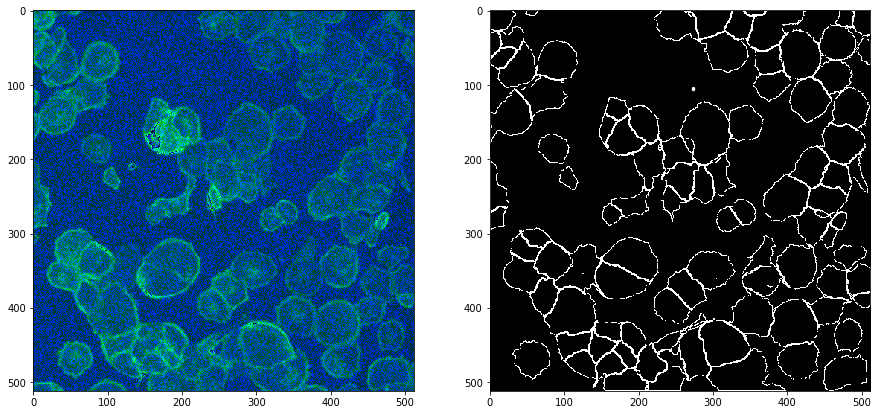

In [2]:
# Human HT29 colon-cancer cells
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
im = imageio.imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp')
plt.imshow(im)
plt.subplot(1,2,2)
mask = imageio.imread('BBBC018_v1_outlines/train/00735-cells.png')
plt.imshow(mask, 'gray')

This time you aren't provided with any code snippets, just input data and target metric - intersection-over-union (IoU) (see implementation below).

You should train neural network to predict mask of edge pixels (pixels in gt images with value greater than 0).

Use everything you've learnt by now: 
* any architectures for semantic segmentation (encoder-decoder like or based on dilated convolutions)
* data augmentation (you will need that since train set consists of just 41 images)
* fine-tuning

You're not allowed to do only one thing: to train you network on test set.

Your final solution will consist of an ipython notebook with code (for final network training + any experiments with data) and an archive with png images with network predictions for test images (one-channel images, 0 - for non-edge pixels, any non-zero value for edge pixels).

Forestalling questions about baseline... well, let's say that a good network should be able to segment images with iou >= 0.29. This is not a strict criterion of full points solution, but try to obtain better numbers.

Practical notes:
* There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for "edge" class, or add class weights to increase the cost of edge pixels in optimized loss.
* Dataset is small so actively use data augmentation: rotations, flip, random contrast and brightness
* Better spend time on experiments with neural network than on postprocessing tricks (i.e test set augmentation).
* Keep in mind that network architecture defines receptive field of pixel. If the size of network input is smaller than receptive field of output pixel, than probably you can throw some layers without loss of quality. It is ok to modify "of-the-shelf" architectures. 

Good luck!

### Helper functions

In [3]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

In [4]:
def show_batch(sample_batched, net=None, threshold=0.2):
    sample_batched = iter(sample_batched).next()
    plt.figure(figsize=(15,20))
    # Gridify only two images and masks
    grid_imgs = utils.make_grid(sample_batched[0], padding=2)
    grid_masks = utils.make_grid(sample_batched[1], padding=2)
    grid = torch.cat((grid_imgs, grid_masks), 1)
    # Is network is given then concat also prediction
    if (net is not None):
        with torch.no_grad():
            net.eval()
            if (next(net.parameters()).is_cuda == False):
                grid_pred = utils.make_grid((net(sample_batched[0]) > threshold).float(), padding=2)
            else:
                grid_pred = utils.make_grid((net(sample_batched[0].cuda()).cpu() > threshold).float(), padding=2)
            grid = torch.cat((grid, grid_pred ), 1)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    if (net is None):
        plt.title('Batch from dataloader (row 1 - images, row 2 - masks)', size=16)
    else:
        plt.title('Batch from dataloader (row 1 - images, row 2 - masks, row 3 - predicted)', size=16)
    plt.axis('off')
    plt.ioff()
    plt.show()

In [5]:
def save_checkpoint(state, filename):
    torch.save(state, filename)

### Define network

For this task I decided to use UNet with padding (it was well-explained on lectures and in an original article as well). Padding is better on not to lose original resolution. The idea is to use fully-convolution network with downscaling and upscaling. At the first glance it seems like downscaling should be enough, but in such a way the network produces images with very low resolution, so the mask will be very blurry. To solve this problem the upscaling technique was introduced. Upscaling increases the resolution of intermediate vector in a learnable way.

https://github.com/jvanvugt/pytorch-unet/blob/master/unet.py

In [6]:
class UNet(nn.Module):
    def __init__(
        self,
        in_channels=3,
        n_classes=1,
        depth=5,
        wf=6,
        padding=True,
        batch_norm=True,
        up_mode='upconv',
    ):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(
                UNetConvBlock(prev_channels, 2 ** (wf + i), padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(
                UNetUpBlock(prev_channels, 2 ** (wf + i), up_mode, padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)
        self.activ = nn.Sigmoid()

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.max_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])

        return self.activ(self.last(x))


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[
            :, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])
        ]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out

### Define a custom dataloader

In [7]:
class CellLoader(Dataset):
    def __init__(self, image_path, mask_path, val=False):
        # paths to all images and masks
        self.image_arr = sorted(glob.glob(image_path + "/*"))
        if (len(mask_path)):
            self.mask_arr = sorted(glob.glob(mask_path + "/*"))
        else:
            self.mask_arr = []
        self.data_len = len(self.image_arr)
        
        if (val == False):
            self.transforms = [
                albumentations.Flip(),
                albumentations.ElasticTransform(alpha=34, sigma=4),
                albumentations.Rotate(),
                albumentations.RandomBrightness(),
            ]
        else:
            self.transforms = []

    def __getitem__(self, index):
        single_image = imageio.imread(self.image_arr[index])
        if (len(self.mask_arr) == 0):
            return TF.to_tensor(single_image).float(), self.image_arr[index]
        
        single_mask = imageio.imread(self.mask_arr[index])
        
        if (len(self.transforms)):
            for transform in self.transforms:
                result = transform(image=single_image, mask=single_mask)
                single_image = result['image']
                single_mask = result['mask']

        return TF.to_tensor(single_image).float(),\
               TF.to_tensor(single_mask).float()

    def __len__(self):
        return self.data_len

### Define parameters

In [28]:
EPOCHS = 100
BATCH_SIZE = 4
ds_train = {
    'imgs' : "BBBC018_v1_images-fixed/train",
    'mask' : "BBBC018_v1_outlines/train"
}
ds_val = {
    'imgs' : "BBBC018_v1_images-fixed/val",
    'mask' : "BBBC018_v1_outlines/val"
}
ds_test = {
    'imgs' : "BBBC018_v1_images-fixed/test",
    'mask' : ""
}

### Load datasets

In [29]:
cell_train = CellLoader(image_path=ds_train['imgs'], mask_path=ds_train['mask'])
cell_train_ld = data.DataLoader(cell_train, batch_size=BATCH_SIZE,
                                shuffle=True,  num_workers=1)

cell_val = CellLoader(image_path=ds_val['imgs'], mask_path=ds_val['mask'], val=True)
cell_val_ld = data.DataLoader(cell_val, batch_size=BATCH_SIZE,
                              shuffle=True,  num_workers=1)

cell_test = CellLoader(image_path=ds_test['imgs'], mask_path=ds_test['mask'], val=True)
cell_test_ld = data.DataLoader(cell_test, batch_size=BATCH_SIZE,
                               shuffle=True,  num_workers=1)

### Show some examples

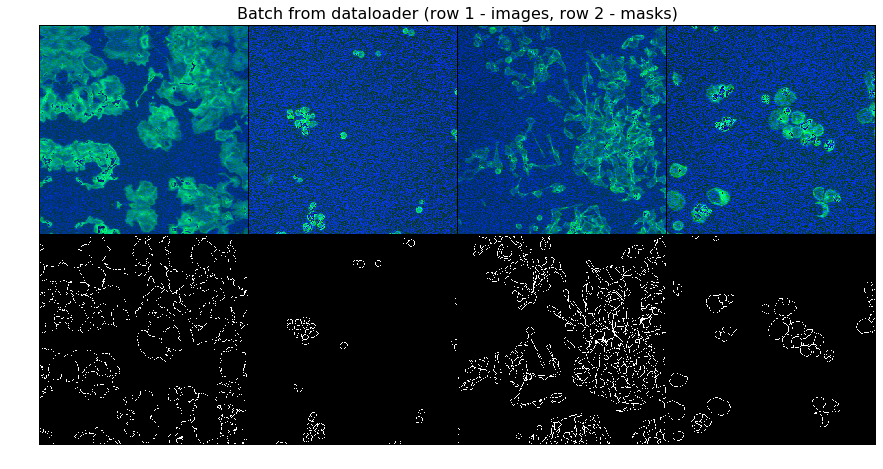

In [10]:
show_batch(cell_train_ld)

### Instantiate the network

In [11]:
net = UNet()
threshold = 0.2
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_history = np.zeros(EPOCHS)
iou_history = np.zeros(EPOCHS)
train_loss_history = np.zeros(EPOCHS)
train_iou_history = np.zeros(EPOCHS)

### Move to GPU if neccesary

In [12]:
ngpu = 1
if torch.cuda.is_available():
    print("Cuda is available")
    net = net.cuda()
else:
    print('Cuda is not available')
    net = net.cpu()

Cuda is available


### Restore the latest checkpoint (if needed)

In [13]:
WEIGHTS_PATH = './weights/hw3_part1_both.pth.tar'

if (torch.cuda.is_available()):
    checkpoint = torch.load(f=WEIGHTS_PATH)
else:
    net = nn.DataParallel(net)
    checkpoint = torch.load(map_location='cpu', f=WEIGHTS_PATH)
    
net.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
last_epoch = checkpoint['epoch']
iou_history = checkpoint['iou_history']
loss_history = checkpoint['loss_history']
train_loss_history = checkpoint['train_loss_history']
train_iou_history = checkpoint['train_iou_history']

### Start training process

In [14]:
running_loss = 0

net.zero_grad()
for epoch in range(EPOCHS):
    # If this epoch has been already passed then print out stored result
    if (train_loss_history[epoch] > 0):
        print("###############################################")
        print("Epoch: " + str(epoch))
        print("Train Loss: ", round(train_loss_history[epoch], 2))
        if (loss_history[epoch] > 0.1):
            print("Train IoU: {}".format(round(train_iou_history[epoch], 2)))
            print('Valid Loss: {}'.format(round(loss_history[epoch],2)))
            print('Valid IoU: {}'.format(round(iou_history[epoch], 2)))
        continue
    # Otherwise train the network
    start = time.time()
    net.train()
    last_iou = 0
    # Train on training dataset
    for steps, (x_batch, y_batch) in enumerate(cell_train_ld):
        x_batch = x_batch.cuda()
        y_batch = y_batch.cuda()
        optimizer.zero_grad()
        predicted = net(x_batch)
        loss = criterion(predicted, y_batch.float())
        loss.backward()
        optimizer.step()
        running_loss = loss.item()
        with torch.no_grad():
            last_iou = calc_iou(predicted.cpu().numpy() > threshold,\
                                y_batch.cpu().numpy())
    
    end = time.time()
    train_loss_history[epoch] = running_loss
    train_iou_history[epoch] = last_iou
    print("###############################################")
    print("Epoch: " + str(epoch) + ", Time: " + str(round(end-start, 2)) + "s")
    print("Train loss: " + str(round(running_loss,2)))
    print('Train IoU: {}'.format(round(last_iou, 2)))

    # Validate the model on every five steps
    if (epoch % 5 != 0):
        continue
        
    # Compute validation loss and accuracy
    with torch.no_grad():
        net.eval()
        count = 0
        total_iou = 0
        for images, masks in cell_val_ld:
            images = images.cuda()
            masks = masks.cuda()
            masks_pred = net(images)
            loss = criterion(masks_pred, masks).item()
            total_iou += calc_iou(masks_pred.cpu().numpy() > threshold,\
                                  masks.cpu().numpy())
            count += 1

        print('Valid Loss: {}'.format(round(loss, 2)))
        print('Valid IoU: {}'.format(total_iou / count))
        iou_history[epoch] = total_iou / count
        loss_history[epoch] = loss

###############################################
Epoch: 0
Train Loss:  0.65
Train IoU: 0.05%
Valid Loss: 0.66
Valid IoU: 0.05302794774373372%
###############################################
Epoch: 1
Train Loss:  0.63
###############################################
Epoch: 2
Train Loss:  0.59
###############################################
Epoch: 3
Train Loss:  0.55
###############################################
Epoch: 4
Train Loss:  0.5
###############################################
Epoch: 5
Train Loss:  0.44
Train IoU: 0.01%
Valid Loss: 0.45
Valid IoU: 0.05306526288482158%
###############################################
Epoch: 6
Train Loss:  0.39
###############################################
Epoch: 7
Train Loss:  0.34
###############################################
Epoch: 8
Train Loss:  0.32
###############################################
Epoch: 9
Train Loss:  0.26
###############################################
Epoch: 10
Train Loss:  0.19
Train IoU: 0.08%
Valid Loss: 0.25
Valid IoU

### Plot training and validation loss

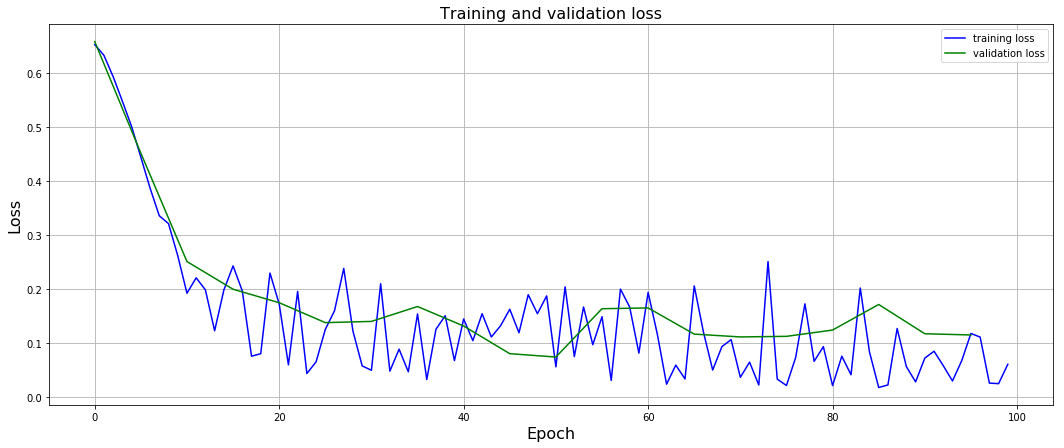

In [15]:
plt.figure(figsize=(18, 7))
plt.title("Training and validation loss", size=16)
plt.xlabel("Epoch", size=16)
plt.ylabel("Loss", size=16)
plt.plot(train_loss_history, 'b', label="training loss")
plt.plot(range(0, EPOCHS, 5), loss_history[0::5], 'g', label="validation loss")
plt.legend()
plt.grid()
plt.show()

### Plot train and validation IoU

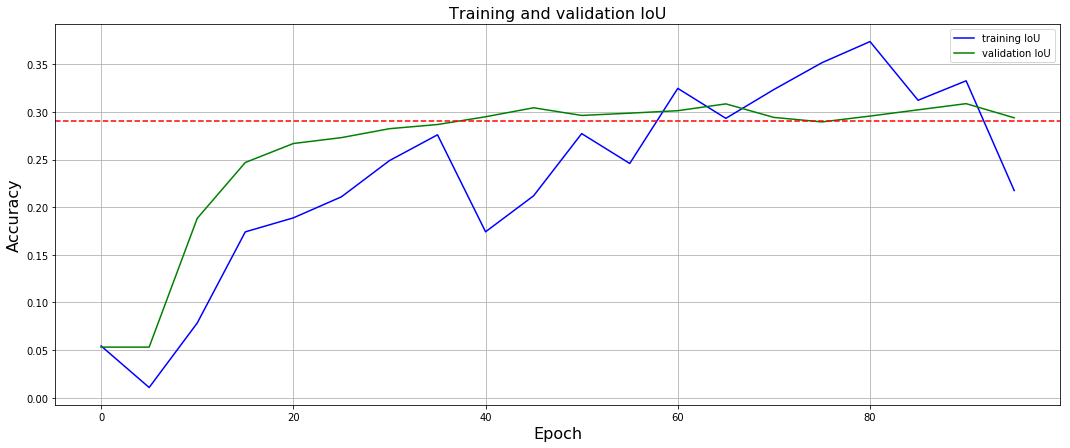

In [16]:
plt.figure(figsize=(18, 7))
plt.title("Training and validation IoU", size=16)
plt.xlabel("Epoch", size=16)
plt.ylabel("Accuracy", size=16)
plt.plot(range(0, EPOCHS, 5), train_iou_history[0::5], 'b', label="training IoU")
plt.plot(range(0, EPOCHS, 5), iou_history[0::5], 'g', label="validation IoU")
plt.axhline(0.29, ls='dashed', c='r')
plt.legend()
plt.grid()
plt.show()

### Save checkpoint (be careful)

In [ ]:
save_checkpoint({
        'epoch': epoch,
        'state_dict': net.state_dict(),
        'optimizer': optimizer.state_dict(),
        'iou_history' : iou_history,
        'loss_history' : loss_history,
        'train_loss_history' : train_loss_history,
        'train_iou_history' : train_iou_history
    }, './weights/hw3_part1_both_mod.pth.tar')

### Demonstrate results (threshold = 0.1)

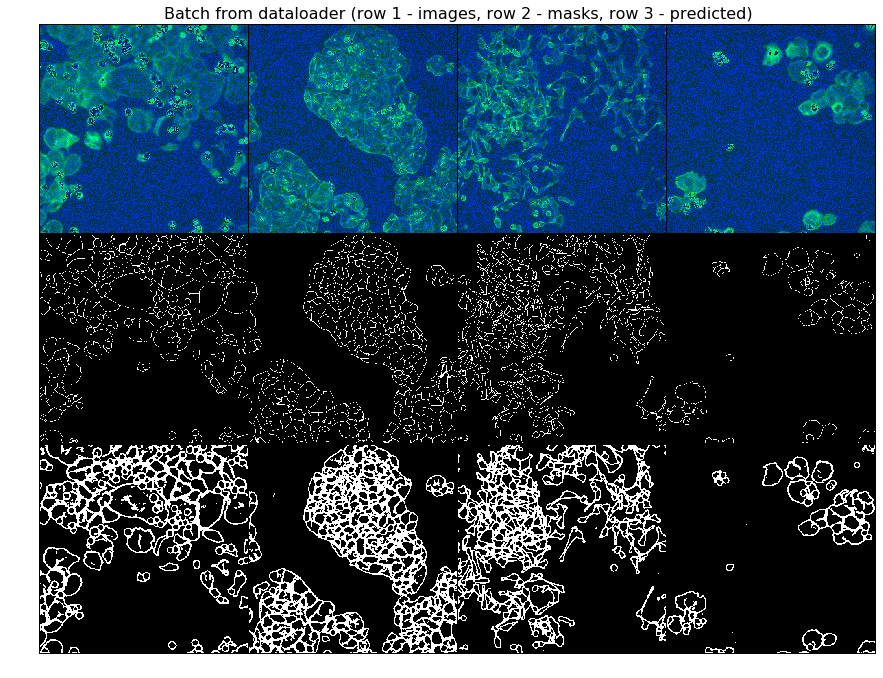

In [17]:
show_batch(cell_val_ld, net, threshold=0.1)

### Demonstrate results (threshold = 0.2)

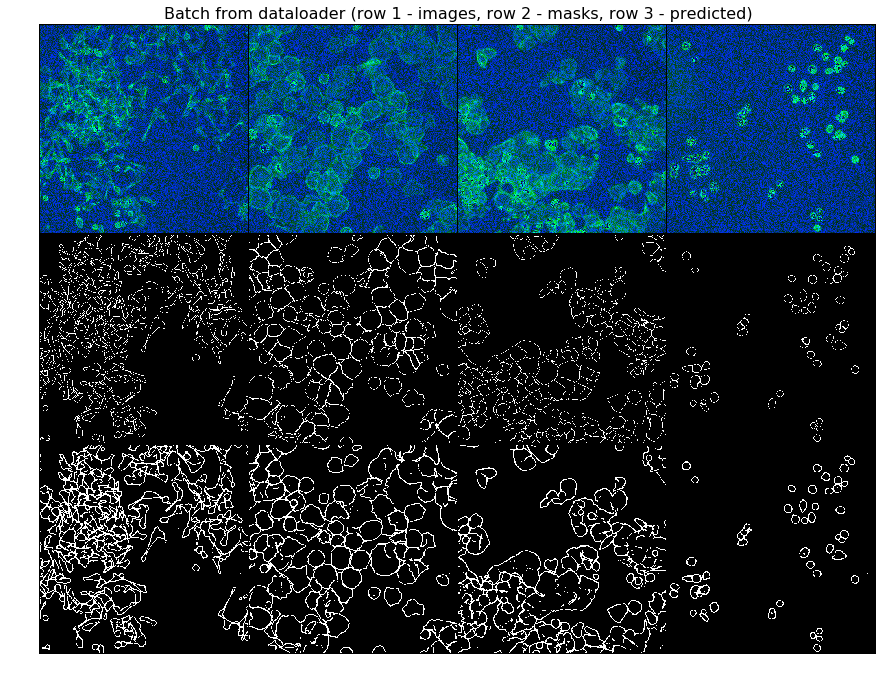

In [18]:
show_batch(cell_val_ld, net, threshold=0.2)

### Demonstrate results (threshold = 0.3)

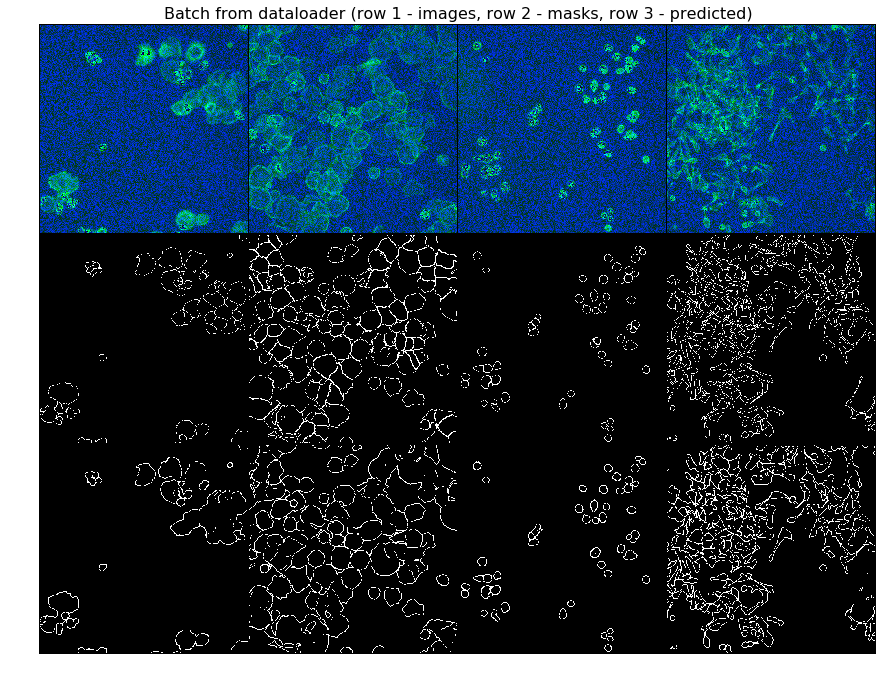

In [19]:
show_batch(cell_val_ld, net, threshold=0.3)

### Demonstrate results (threshold = 0.5)

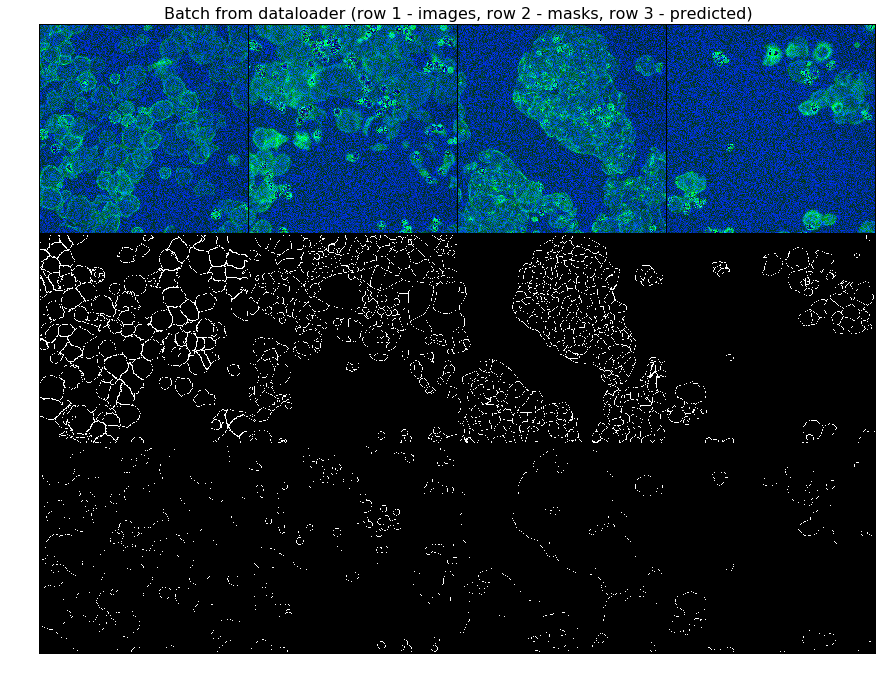

In [20]:
show_batch(cell_val_ld, net, threshold=0.5)

### Save masks for test pictures

In [30]:
TEST_DIR = "./test_masks/"

for x_batch, names in cell_test_ld:
    with torch.no_grad():
        masks = (net(x_batch.cuda()) > 0.2)
    for mask, name in zip(masks, names):
        path, fname = os.path.split(name)
        print(fname, mask.shape)
        imageio.imwrite(TEST_DIR + fname, (mask * 255).squeeze().cpu().numpy().astype(np.uint8))

19466-actin.DIB.bmp torch.Size([1, 512, 512])
13361-actin.DIB.bmp torch.Size([1, 512, 512])
10780-actin.DIB.bmp torch.Size([1, 512, 512])
05624-actin.DIB.bmp torch.Size([1, 512, 512])
13569-actin.DIB.bmp torch.Size([1, 512, 512])
05899-actin.DIB.bmp torch.Size([1, 512, 512])
00733-actin.DIB.bmp torch.Size([1, 512, 512])


### Check test masks

In [31]:
ds_test = {
    'imgs' : "BBBC018_v1_images-fixed/test",
    'mask' : "./test_masks"
}
cell_test = CellLoader(image_path=ds_test['imgs'], mask_path=ds_test['mask'], val=True)
cell_test_ld = data.DataLoader(cell_test, batch_size=BATCH_SIZE,
                               shuffle=True,  num_workers=1)

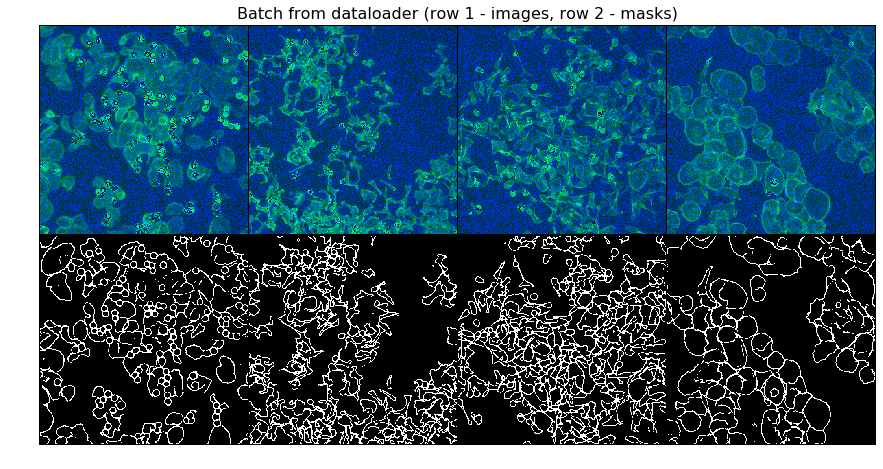

In [32]:
show_batch(cell_test_ld)